## Unsupervised Machine Learning with K-means Clustering

### The notebook will be broken down into a few steps:

1) Loading and exploring the data

2) Exploratory Data Analysis (w. Visualization)

3) Training a K-means Clustering model

4) Implementing the Elbow Method for finding k-value 

5) Predict test dataset's values

In [8]:
### ignore depreciated warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Step 1: Load data

In [10]:
df = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/DBSCAN-Algorithm/master/Mall_Customers.csv")
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [11]:
df.shape

(200, 5)

As we can see from the table below, our dataset has 5 columns: CustomerID, Genre, Age, Annual Income (in thousands of dollars), and Spending score (1-100). Higher spending score means higher spending in the past.

There are about 200 records (rows) in our dataset with 5 columns.

#### Let's check for missing values

In [12]:
df.isnull().values.any()

False

It looks like we do not have any missing values in our dataset.

### Step 2: Visualize data

#### Plot a histogram for the numerical variables: Age, Annual Income, and Spending score

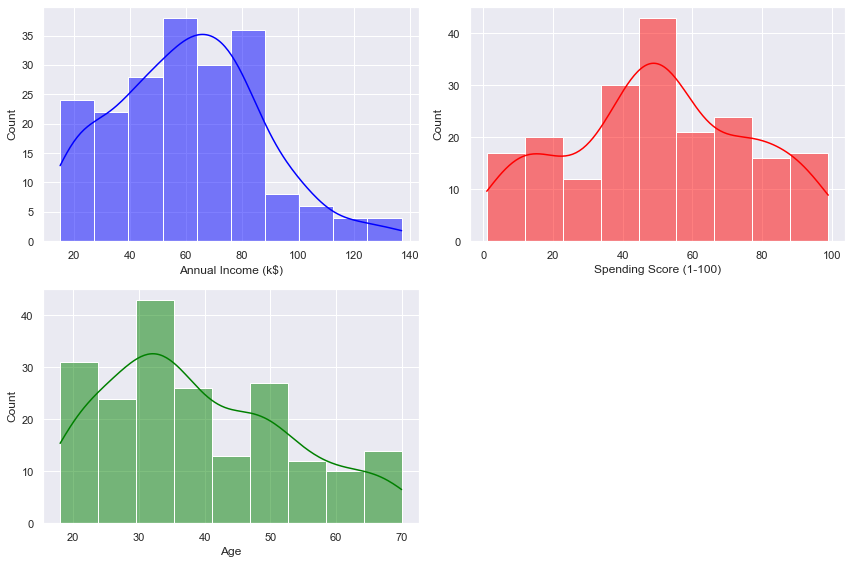

In [20]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 3 columns)
fig, axes = plt.subplots(2, 2,  figsize=(12,8))

sns.histplot(df["Annual Income (k$)"], kde=True, color="blue", ax=axes[0, 0])
sns.histplot(df["Spending Score (1-100)"], kde=True, color="red", ax=axes[0, 1])
sns.histplot(df["Age"], kde=True, color="green", ax=axes[1, 0])

fig.delaxes(axes[1,1])
fig.tight_layout()

### Plot regression plots to see the relationships between Age vs Spending Score, Age vs Annual Income, Spending Score vs Age. 

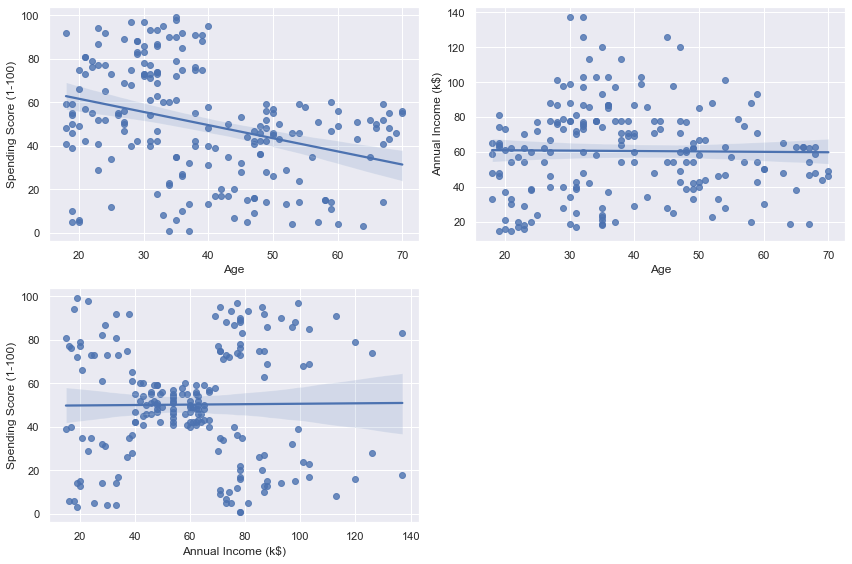

In [21]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 3 columns)
fig, axes = plt.subplots(2, 2, figsize=(12,8))

sns.regplot(x=df["Age"], y="Spending Score (1-100)", data=df, ax=axes[0, 0])
sns.regplot(x=df["Age"], y="Annual Income (k$)", data=df, ax=axes[0, 1])
sns.regplot(x=df["Annual Income (k$)"], y="Spending Score (1-100)", data=df, ax=axes[1, 0])

fig.delaxes(axes[1,1])
fig.tight_layout()

We can see that there seems to be a downward trend in the Spending Score vs Age regression plot. This is not to say there exists correlation between the two features, but to observe a pattern that the chart shows us.

After pre-processing the data for training, we will examine multicollinearity among these variables.

### Let's analyze the Spending Score of the Customers

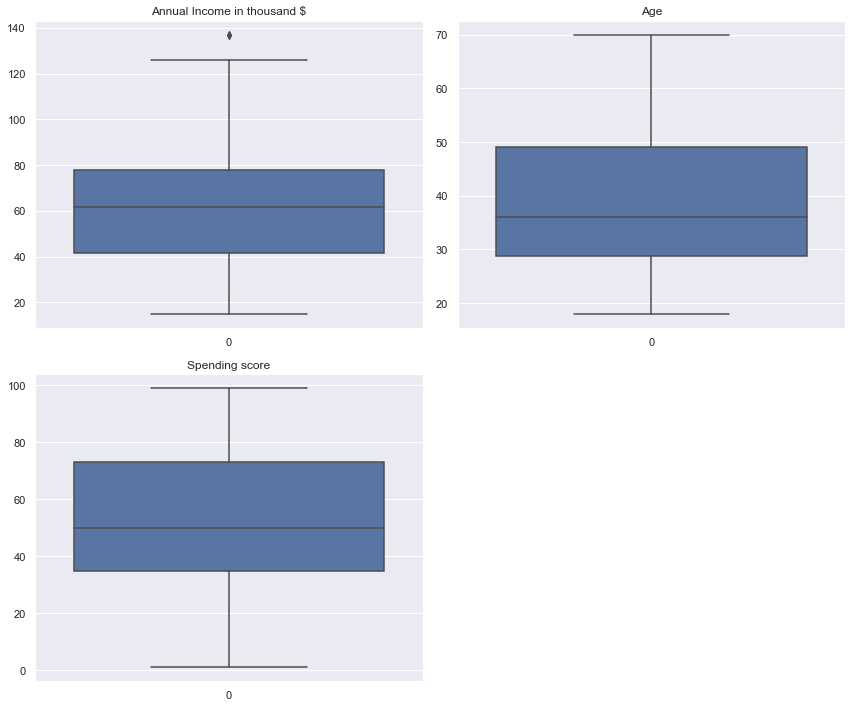

In [22]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 3 columns)
fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.boxplot(data=df['Annual Income (k$)'], ax=axes[0, 0]).set(title='Annual Income in thousand $')
sns.boxplot(data=df['Age'], ax=axes[0, 1]).set(title='Age')
sns.boxplot(data=df['Spending Score (1-100)'], ax=axes[1, 0]).set(title='Spending score')

fig.delaxes(axes[1,1])

fig.tight_layout()

### Step 3: Clean data

We will drop the CustomerID feature because it is just a unique identifier and does not provide us with any useful information. 

We will one hot encode categorical variable Genre. 

For Age, Annual Income, and Spending Score, we will standardize them such that they follow the standard normal distribution of mean 0 and std of 1. 

In [23]:
# drop CustomerID
df.drop(columns = ["CustomerID"])

# Standardize age:
num_col_names = ['Annual Income (k$)', 'Age', 'Spending Score (1-100)']
features = df[num_col_names]
scaler = StandardScaler()
scaler.fit(features.values)
features = scaler.transform(features.values)

scaled_features = pd.DataFrame(features, columns = num_col_names)

In [24]:
scaled_features

,Annual Income (k$),Age,Spending Score (1-100)
0,-1.738999,-1.424569,-0.434801
1,-1.738999,-1.281035,1.195704
2,-1.700830,-1.352802,-1.715913
3,-1.700830,-1.137502,1.040418
4,-1.662660,-0.563369,-0.395980
...,...,...,...
195,2.268791,-0.276302,1.118061
196,2.497807,0.441365,-0.861839
197,2.497807,-0.491602,0.923953
198,2.917671,-0.491602,-1.250054


In [28]:
# One hot encode Gender
gender = df['Genre']
scaled_df = scaled_features.join(gender)
scaled_df = pd.get_dummies(scaled_df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)
scaled_df = scaled_df.drop(columns=["Genre_Male"])
scaled_df

,Annual Income (k$),Age,Spending Score (1-100),Genre_Female
0,-1.738999,-1.424569,-0.434801,0
1,-1.738999,-1.281035,1.195704,0
2,-1.700830,-1.352802,-1.715913,1
3,-1.700830,-1.137502,1.040418,1
4,-1.662660,-0.563369,-0.395980,1
...,...,...,...,...
195,2.268791,-0.276302,1.118061,1
196,2.497807,0.441365,-0.861839,1
197,2.497807,-0.491602,0.923953,0
198,2.917671,-0.491602,-1.250054,0


Note that we have dropped the column "Genre_Male" as our column Genre_Female now is the binary column with 0 means the gender is Male (M) and 1 means Female (F). 

#### Multicollinearity Check

As mentioned before, we will check if there exists any multicollinearity among the predictors before moving to training the model. We can see a slightly negative correlation between Age and Spending Score. This could signal collinearity between these 2 variables. Let's look at the Variance Inflation Factor for each variable.  

In [27]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = scaled_df.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(scaled_df.values, i) for i in range(scaled_df.shape[1])]
  
print(vif_data)

                  feature       VIF
0      Annual Income (k$)  1.001649
1                     Age  1.121018
2  Spending Score (1-100)  1.120783
3            Genre_Female  1.003814


The VIFs are all around 1, which means that there are actually no multi-collinearity between any variable and the other variables. Let's move on to training our model.

### Step 3: Training a K-means Clustering model

Text(0, 0.5, 'Inertia')

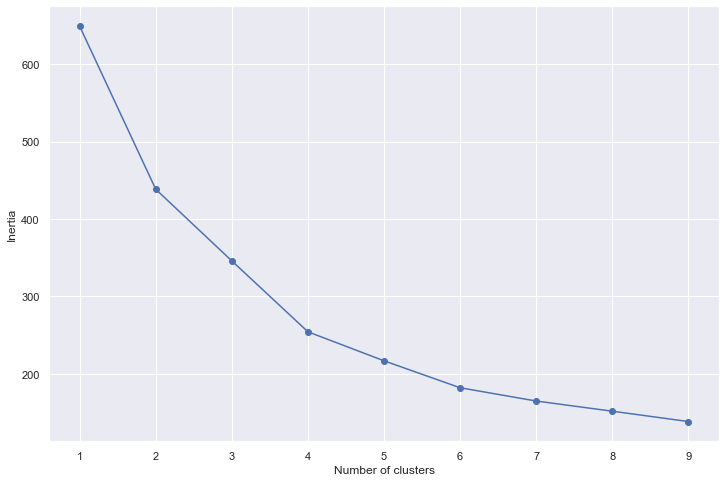

In [31]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(scaled_df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,8))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

#### We can see that the optimal number of clusters is 4. 

#### Let us look at the 2 main metrics to evaluate the optimal number of clusters to use:

1. Elbow method (shown in the graph above, we can see that 4 is the optimal number of clusters)
2. Silhouette method

#### Method 2: Silhouette method

The silhouette score (frrom -1 to +1) measures the distance between all the data points within the same cluster. Our objective is to minimize the distance between all data points within the same cluster. 

Let a = the mean of intra-cluster distance
Let b = the mean of nearest-cluster distance

Silhouette coeff = (b-a) / max(a,b)

For an optimal k clusters, we want the mean distance between a point to all the points within the same clusters to be smallest it can be (a), and the mean distance from that point to all the points in the nearest (different) cluster to be biggest (b). We pick the highest Silhouette coeff number. 

Let's build 4 clusters:

In [32]:
km_model = KMeans(n_jobs = -1, n_clusters=4, init='k-means++')
km_model.fit(scaled_df)

# Let's see the silhouette score of this model

print(silhouette_score(scaled_df, kmeans.labels_, metric='euclidean'))

0.3429867771884663


Now, let's visualize 4 clusters in a higher dimensional graph:

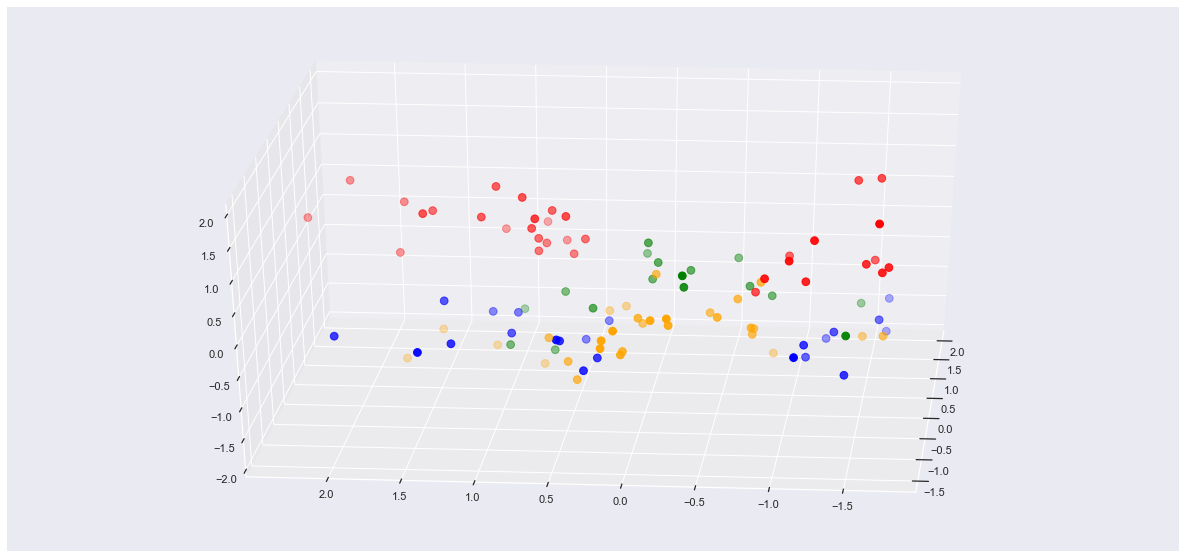

In [33]:
clusters = kmeans.fit_predict(scaled_df.iloc[:,1:])
scaled_df["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_df.Age[scaled_df.label == 0], scaled_df["Annual Income (k$)"][scaled_df.label == 0], scaled_df["Spending Score (1-100)"][scaled_df.label == 0], c='blue', s=60)

ax.scatter(scaled_df.Age[scaled_df.label == 1], scaled_df["Annual Income (k$)"][scaled_df.label == 1], scaled_df["Spending Score (1-100)"][scaled_df.label == 1], c='red', s=60)
ax.scatter(scaled_df.Age[scaled_df.label == 2], scaled_df["Annual Income (k$)"][scaled_df.label == 2], scaled_df["Spending Score (1-100)"][scaled_df.label == 2], c='green', s=60)
ax.scatter(scaled_df.Age[scaled_df.label == 3], scaled_df["Annual Income (k$)"][scaled_df.label == 3], scaled_df["Spending Score (1-100)"][scaled_df.label == 3], c='orange', s=60)

ax.view_init(30, 185)
plt.show()

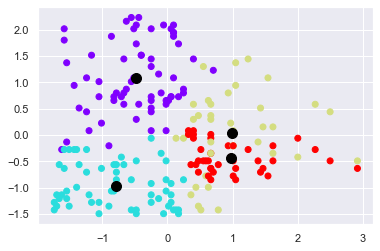

In [48]:
#print the datapoints (in 4 different colors)
plt.scatter(scaled_df.values[:,0], scaled_df.values[:,1], c=km_model.labels_, cmap='rainbow')

# print the centroids (in black)
plt.scatter(km_model.cluster_centers_[:,0], km_model.cluster_centers_[:,1], s=100, c="black")

As the silhouette score is ~0.34, let's see if we can get to a higher score. 

#### Let's use Principle Analysis Components (PCA) to select the most important features for our model. 

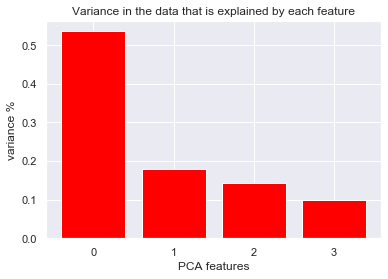

In [49]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(scaled_df)

pca_features = range(pca.n_components_)
plt.bar(pca_features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(pca_features)
plt.title("Variance in the data that is explained by each feature") 

PCA_components = pd.DataFrame(principalComponents)

We see that the first feature explained close to 70% of the variance in the dataset. Let's pick feature 0 and 1 that combined explains about 80% of the dataset variance. 

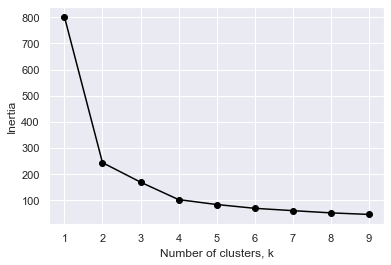

            0         1
0    1.308895 -1.779741
1    1.959218 -1.937653
2   -0.970022 -1.730820
3    2.689892 -1.867143
4   -1.496527 -1.766375
..        ...       ...
195  2.675789  2.144260
196 -1.775173  2.513150
197  1.832616  2.363498
198 -0.771404  2.924308
199  2.047501  2.715528

[200 rows x 2 columns]


In [58]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()
print(PCA_components.iloc[:,:2])

It seems like the optimal number of clusters after doing PCA work is still 4. Let's see whether or not our sihlouette score improves.

In [51]:
model_PCA = KMeans(n_clusters=4)
model_PCA.fit(PCA_components.iloc[:,:2])

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:2], model_PCA.labels_, metric='euclidean')) 

0.49517720574914464


It looks like the silhouette score improves from 0.35 to 0.49. This is not too bad of a score. Now's let's look at the higher dimensional graph of the clusters. 

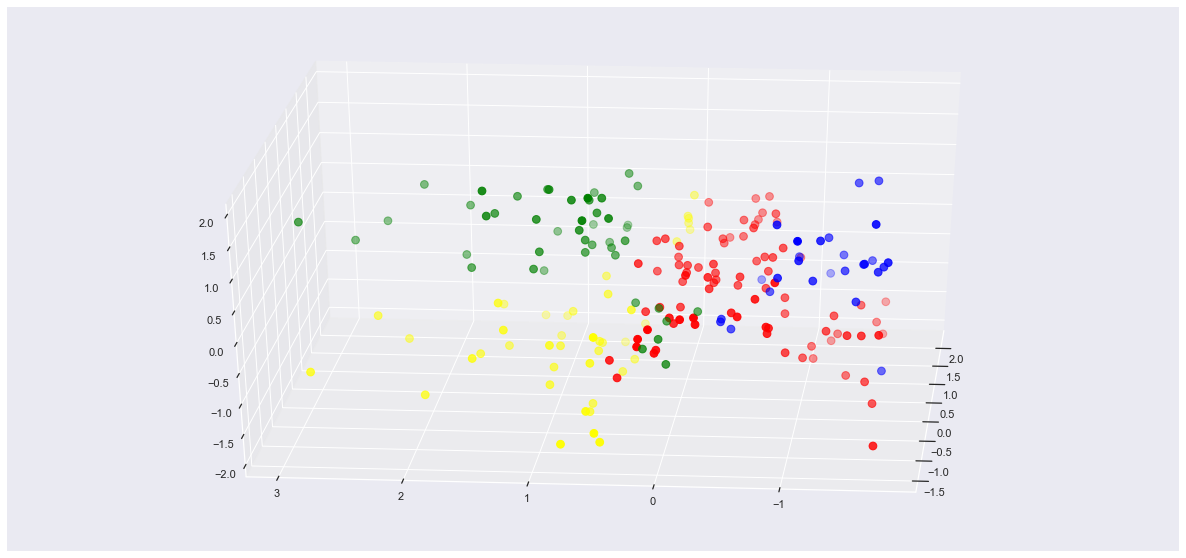

In [53]:
model = KMeans(n_clusters=4)
clusters_PCA = model.fit_predict(PCA_components.iloc[:,:2])
scaled_df["label"] = clusters_PCA
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scaled_df.Age[scaled_df.label == 0], scaled_df["Annual Income (k$)"][scaled_df.label == 0], scaled_df["Spending Score (1-100)"][scaled_df.label == 0], c='blue', s=60)
ax.scatter(scaled_df.Age[scaled_df.label == 1], scaled_df["Annual Income (k$)"][scaled_df.label == 1], scaled_df["Spending Score (1-100)"][scaled_df.label == 1], c='red', s=60)
ax.scatter(scaled_df.Age[scaled_df.label == 2], scaled_df["Annual Income (k$)"][scaled_df.label == 2], scaled_df["Spending Score (1-100)"][scaled_df.label == 2], c='green', s=60)
ax.scatter(scaled_df.Age[scaled_df.label == 3], scaled_df["Annual Income (k$)"][scaled_df.label == 3], scaled_df["Spending Score (1-100)"][scaled_df.label == 3], c='yellow', s=60)
ax.view_init(30, 185)
plt.show()

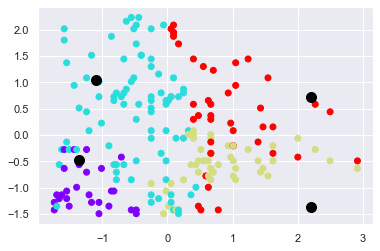

In [54]:
#print the datapoints (in 4 different colors)
plt.scatter(scaled_df.values[:,0], scaled_df.values[:,1], c=model.labels_, cmap='rainbow')

# print the centroids (in black)
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=100, c="black")

We see that the 4 clusters through PCA the 2 most important features are more "separable" than pre-PCA clusters. Let's see how the clusters divide our original data points. 

In [55]:
# map back clusters to dataframe
df = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/DBSCAN-Algorithm/master/Mall_Customers.csv")
df = df.drop(['CustomerID'],axis=1)

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame.head(10)

,Genre,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,0
1,Male,21,15,81,0
2,Female,20,16,6,1
3,Female,23,16,77,0
4,Female,31,17,40,1
5,Female,22,17,76,0
6,Female,35,18,6,1
7,Female,23,18,94,0
8,Male,64,19,3,1
9,Female,30,19,72,0


In [56]:
avg_df = df.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Age,Annual Income (k$),Spending Score (1-100)
0,0,24.592593,28.333333,74.740741
1,1,44.576471,47.082353,41.482353
2,2,31.195652,82.652174,77.304348
3,3,44.809524,84.357143,22.380952


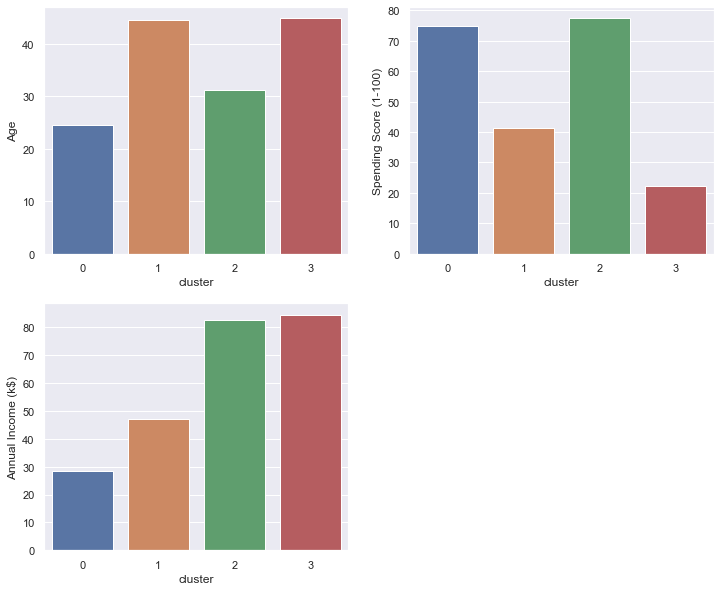

In [57]:
#set seaborn plotting aesthetics as default
sns.set()

#define plotting region (1 row, 3 columns)
fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.barplot(x='cluster',y='Age',data=avg_df, ax=axes[0, 0])
sns.barplot(x='cluster',y='Spending Score (1-100)',data=avg_df, ax=axes[0, 1])
sns.barplot(x='cluster',y='Annual Income (k$)',data=avg_df, ax=axes[1, 0])

fig.delaxes(axes[1,1])

### Step 4: Conclusion

We conclude the following representation for each cluster:

#### Cluster 0: Young (average 25 years old), High spending score (~ 65-67), Low Annual Income (~30k) 

#### Cluster 1: Early 40s, Low spending score (~ 20), Very High Annual Income (~93k)

#### Cluster 2: Middle aged (Mid 50s), Average Spending score (~ 40), Average Annual Income (~ 45k-50k)

#### Cluster 3: Young - Early 30s, Very High Spending score (70), High Annual Income (~ 80k)  